In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import os

# from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor
from sklearn.datasets import load_diabetes, make_friedman1
from sklearn.ensemble import ExtraTreesRegressor, AdaBoostRegressor, GradientBoostingRegressor, RandomForestRegressor
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor

from evolutionary_forest.forest import EvolutionaryForestRegressor
from evolutionary_forest.utils import get_feature_importance, plot_feature_importance, feature_append

/home/howt51/work/vscode_micromamba/kaggle/evolution_forest/.micromamba/envs/evolutionforest/lib/python3.8/site-packages/shap/utils/_clustering.py:35: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def _pt_shuffle_rec(i, indexes, index_mask, partition_tree, M, pos):
/home/howt51/work/vscode_micromamba/kaggle/evolution_forest/.micromamba/envs/evolutionforest/lib/python3.8/site-packages/shap/utils/_clustering.py:54: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/refer

In [2]:
train_df = pd.read_csv('/home/howt51/work/vscode_micromamba/kaggle/data/playground-series-s3e18/train.csv')
test_df = pd.read_csv('/home/howt51/work/vscode_micromamba/kaggle/data/playground-series-s3e18/test.csv')

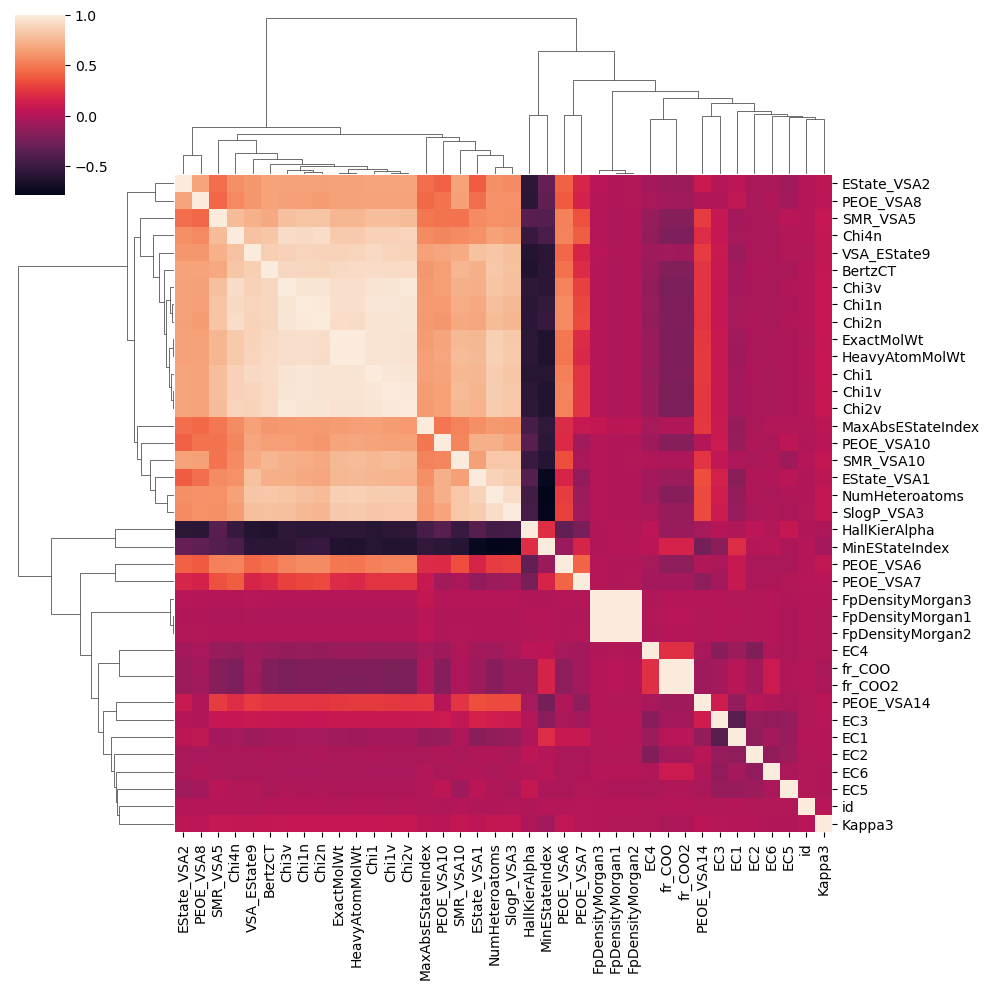

In [3]:
sns.clustermap(train_df.corr())

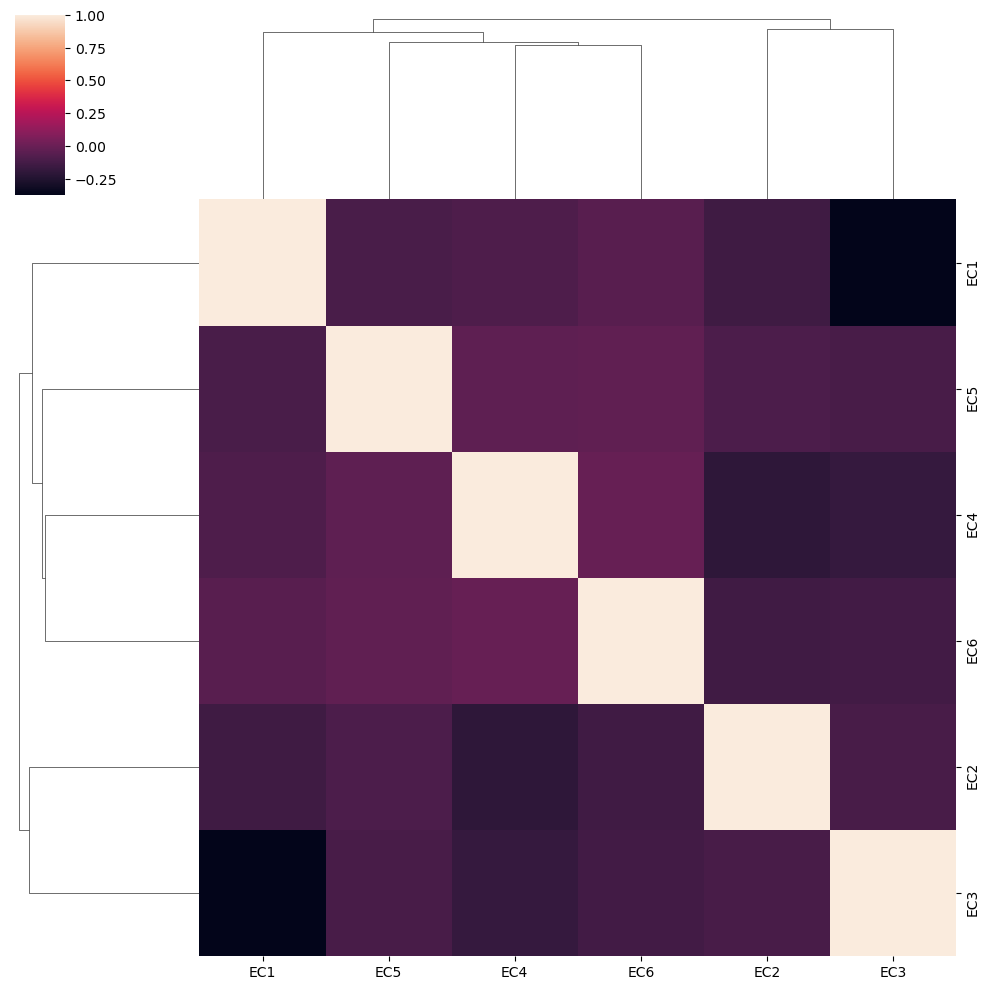

In [4]:
sns.clustermap(train_df[['EC1','EC2', 'EC3', 'EC4', 'EC5', 'EC6']].corr())

In [5]:
def process(df):
    df['MolWt'] = df['HeavyAtomMolWt'] + df['ExactMolWt']
    df['NumRotatableBonds'] = df['Chi3v'] + df['Chi4n']
    df['NumAromaticRings'] = df['BertzCT'] - df['Chi1']
    df.drop(['fr_COO2', 'FpDensityMorgan2', 'FpDensityMorgan3', 'Chi1v', 'Chi1n', 'Chi2n', 'Chi2v', 'Chi3v', 'Chi4n'], axis=1,inplace=True)
    if 'EC3' in df.columns:
        df.drop(['EC3', 'EC4', 'EC5', 'EC6'], axis=1,inplace=True)
    return df
train_df = process(train_df)
test_df = process(test_df)

In [6]:
# test_df.columns

In [7]:
train_df_ = train_df.copy()

# y = train_df_[['EC1', 'EC2']]
train_y1 = train_df_['EC1']
train_y2 = train_df_['EC2']
train_X = train_df_.drop(['EC1', 'EC2'], axis=1)

In [8]:
# Get the number of columns in the DataFrame
num_columns = len(train_X.columns)

# Convert column names to A-Z in order
column_names = []
for i in range(num_columns):
    if i < 26:
        column_names.append(chr(65 + i))
    else:
        column_names.append(str(i - 25))

column_names = ['A'+i for i in column_names]
#columns dict from original to mapped
features_dict = dict(zip(train_X.columns, column_names))
train_X.columns = column_names

In [9]:
features_dict

{'id': 'AA',
 'BertzCT': 'AB',
 'Chi1': 'AC',
 'EState_VSA1': 'AD',
 'EState_VSA2': 'AE',
 'ExactMolWt': 'AF',
 'FpDensityMorgan1': 'AG',
 'HallKierAlpha': 'AH',
 'HeavyAtomMolWt': 'AI',
 'Kappa3': 'AJ',
 'MaxAbsEStateIndex': 'AK',
 'MinEStateIndex': 'AL',
 'NumHeteroatoms': 'AM',
 'PEOE_VSA10': 'AN',
 'PEOE_VSA14': 'AO',
 'PEOE_VSA6': 'AP',
 'PEOE_VSA7': 'AQ',
 'PEOE_VSA8': 'AR',
 'SMR_VSA10': 'AS',
 'SMR_VSA5': 'AT',
 'SlogP_VSA3': 'AU',
 'VSA_EState9': 'AV',
 'fr_COO': 'AW',
 'MolWt': 'AX',
 'NumRotatableBonds': 'AY',
 'NumAromaticRings': 'AZ'}

In [10]:
train_X

,AA,AB,AC,AD,AE,AF,AG,AH,AI,AJ,...,AQ,AR,AS,AT,AU,AV,AW,AX,AY,AZ
0,0,323.390782,9.879918,0.000000,11.938294,222.068080,1.181818,-0.24,212.163,8.170000,...,0.000000,0.000000,17.744066,0.000000,4.794537,35.527357,0,434.231080,4.503716,313.510864
1,1,273.723798,7.259037,45.135471,0.000000,260.029719,1.346154,-0.09,247.031,3.201491,...,0.000000,0.000000,7.822697,30.705892,13.825658,44.707310,0,507.060719,3.491149,266.464760
2,2,521.643822,10.911303,15.645394,6.606882,382.131027,1.085714,-0.78,354.106,15.033890,...,53.378235,0.000000,15.645394,73.143616,17.964475,45.660120,0,736.237026,7.595401,510.732520
3,3,567.431166,12.453343,95.639554,0.000000,530.070277,1.162791,-1.30,506.124,6.724301,...,0.000000,6.420822,15.645394,62.107304,31.961948,87.509997,0,1036.194277,10.981723,554.977822
4,4,112.770735,4.414719,17.980451,12.841643,118.062994,1.444444,-1.10,108.056,3.931272,...,19.386400,0.000000,11.938611,18.883484,9.589074,33.333333,2,226.118994,1.764114,108.356015
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14833,14833,632.207041,10.911303,32.971529,6.606882,347.063084,1.562500,-1.87,333.112,4.879408,...,13.847474,6.923737,34.407699,32.607024,18.947452,61.376610,0,680.175084,5.441107,621.295738
14834,14834,62.568425,2.642734,0.000000,0.000000,74.024203,2.666667,-0.53,70.027,0.729375,...,0.000000,6.066367,0.000000,6.420822,0.000000,10.000000,0,144.051203,0.174620,59.925691
14835,14835,981.327476,10.363081,17.248535,0.000000,297.089560,1.461538,-3.15,282.220,2.045502,...,0.000000,23.762553,10.969244,0.000000,0.000000,66.666667,0,579.309560,5.198743,970.964395
14836,14836,299.171248,9.949161,45.623794,0.000000,265.959270,0.950000,-0.44,257.119,8.424399,...,0.000000,0.000000,7.822697,108.961047,9.088795,45.583333,0,523.078270,6.278806,289.222087


## EC1 Evolutionary Forest Regressor

In [11]:
r = EvolutionaryForestRegressor(max_height=5, normalize=True, select='AutomaticLexicase',
                                gene_num=10, boost_size=100, n_gen=20, n_pop=200, cross_pb=1,
                                base_learner='Random-DT', verbose=True, n_process=1)
r.fit(train_X, train_y1)
# print(r2_score(y_test, r.predict(x_test)))

data shape (14838, 26) (14838,)
   	      	                                                          fitness                                                           	                                  size                                  
   	      	----------------------------------------------------------------------------------------------------------------------------	------------------------------------------------------------------------
gen	nevals	25%         	75%          	avg          	gen	max          	median       	min          	nevals	std         	25%	75%	avg 	gen	max	median	min	nevals	std     
0  	200   	[-0.8153953]	[-0.78699071]	[-0.80159687]	0  	[-0.75223113]	[-0.80072605]	[-0.85086025]	200   	[0.02093731]	3  	4  	3.68	0  	5  	4     	3  	200   	0.589576
defaultdict(<class 'int'>, {'1': 200})
P value of different population 0.8999950372363642
Sub(AY, Sub(AT, AU))
Sub(AL, AV)
Mul(Mul(AE, AA), AQ(AZ, AX))
Mul(AO, 0)
AQ(AQ(AS, AM), Mul(AV, 1))
AQ(AG, AI)
AQ(AK, AI)
AQ(Add

EvolutionaryForestRegressor(basic_primitives='Add,Sub,Mul,AQ', boost_size=100,
                            cross_pb=1, gene_num=10, mab_parameter={},
                            map_elite_parameter={}, max_height=5, n_pop=200,
                            select='AutomaticLexicase', verbose=True)

In [12]:
code_importance_dict = get_feature_importance(r, simple_version=False)
code_importance_dict

{'lambda AA,AB,AC,AD,AE,AF,AG,AH,AI,AJ,AK,AL,AM,AN,AO,AP,AQ,AR,AS,AT,AU,AV,AW,AX,AY,AZ: AQ(Add(AS, AK), Sub(AF, AI))': 0.009497103460513644,
 'lambda AA,AB,AC,AD,AE,AF,AG,AH,AI,AJ,AK,AL,AM,AN,AO,AP,AQ,AR,AS,AT,AU,AV,AW,AX,AY,AZ: Add(AT, AQ)': 0.009299763642194347,
 'lambda AA,AB,AC,AD,AE,AF,AG,AH,AI,AJ,AK,AL,AM,AN,AO,AP,AQ,AR,AS,AT,AU,AV,AW,AX,AY,AZ: AQ(AL, -1)': 0.009175476609509485,
 'lambda AA,AB,AC,AD,AE,AF,AG,AH,AI,AJ,AK,AL,AM,AN,AO,AP,AQ,AR,AS,AT,AU,AV,AW,AX,AY,AZ: Add(AI, AZ)': 0.00912756619163333,
 'lambda AA,AB,AC,AD,AE,AF,AG,AH,AI,AJ,AK,AL,AM,AN,AO,AP,AQ,AR,AS,AT,AU,AV,AW,AX,AY,AZ: Add(Add(AP, AI), AQ(AB, AW))': 0.008803680990455006,
 'lambda AA,AB,AC,AD,AE,AF,AG,AH,AI,AJ,AK,AL,AM,AN,AO,AP,AQ,AR,AS,AT,AU,AV,AW,AX,AY,AZ: Sub(AX, AF)': 0.00878392767304625,
 'lambda AA,AB,AC,AD,AE,AF,AG,AH,AI,AJ,AK,AL,AM,AN,AO,AP,AQ,AR,AS,AT,AU,AV,AW,AX,AY,AZ: AQ(AN, AM)': 0.007942606834611897,
 'lambda AA,AB,AC,AD,AE,AF,AG,AH,AI,AJ,AK,AL,AM,AN,AO,AP,AQ,AR,AS,AT,AU,AV,AW,AX,AY,AZ: Sub(AR, AN)': 

In [13]:
# EState_VSA2- SlogP_VSA3
# fr_COO/sqrt(EC3**2+1)
# EC5/sqrt(EC3**2+1)
# EC3 - EC4
# PEOE_VSA7/sqrt(NumHeteroatoms**2+1)

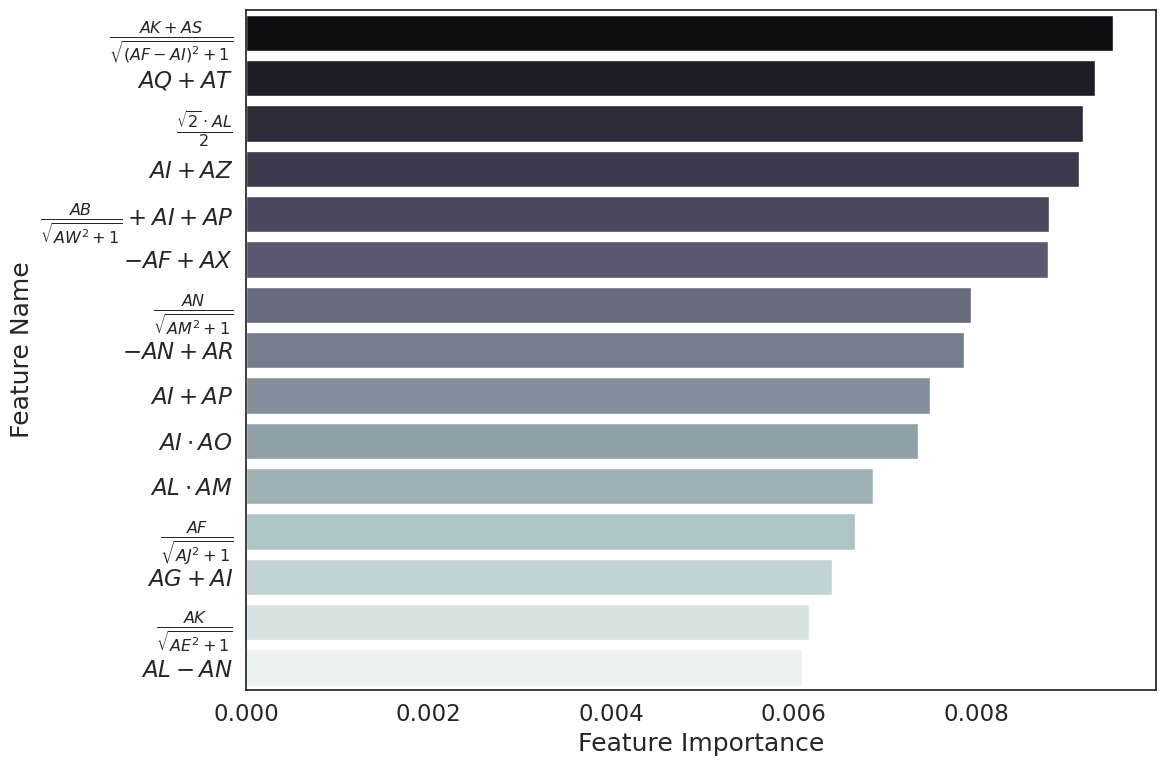

In [14]:
from evolutionary_forest.utils import get_feature_importance, plot_feature_importance

code_importance_dict = get_feature_importance(r)
plot_feature_importance(code_importance_dict)

## EC2 Evolutionary Forest Regressor

In [15]:
r = EvolutionaryForestRegressor(max_height=5, normalize=True, select='AutomaticLexicase',
                                gene_num=10, boost_size=100, n_gen=20, n_pop=200, cross_pb=1,
                                base_learner='Random-DT', verbose=True, n_process=1)
r.fit(train_X, train_y2)
# print(r2_score(y_test, r.predict(x_test)))

data shape (14838, 26) (14838,)
   	      	                                                          fitness                                                           	                                  size                                 
   	      	----------------------------------------------------------------------------------------------------------------------------	-----------------------------------------------------------------------
gen	nevals	25%          	75%          	avg         	gen	max          	median       	min          	nevals	std         	25%	75%	avg 	gen	max	median	min	nevals	std    
0  	200   	[-1.07278887]	[-1.04293551]	[-1.0580636]	0  	[-0.99387068]	[-1.05703051]	[-1.11638967]	200   	[0.02109475]	3  	4  	3.71	0  	6  	4     	3  	200   	0.65261
defaultdict(<class 'int'>, {'1': 200})
P value of different population 0.0009272718622098232
AQ(AA, AR)
Add(AB, AS)
Add(AA, AA)
Mul(Add(AC, AC), Add(-1, AH))
Sub(Sub(AC, AU), AQ(AU, AV))
Add(Mul(AO, AW), Add(AX, AY))
Sub(A

EvolutionaryForestRegressor(basic_primitives='Add,Sub,Mul,AQ', boost_size=100,
                            cross_pb=1, gene_num=10, mab_parameter={},
                            map_elite_parameter={}, max_height=5, n_pop=200,
                            select='AutomaticLexicase', verbose=True)

In [16]:
# EC6 * HallKierAlpha + Kappa3 + EC3
# EState_VSA1 + HeavyAtomMolWt/sqrt(MaxAbsEStateIndex**2+1) - SMR_VSA5
# EState_VSA1 + PEOE_VSA10
# NumHeteroatoms + SlogP_VSA3

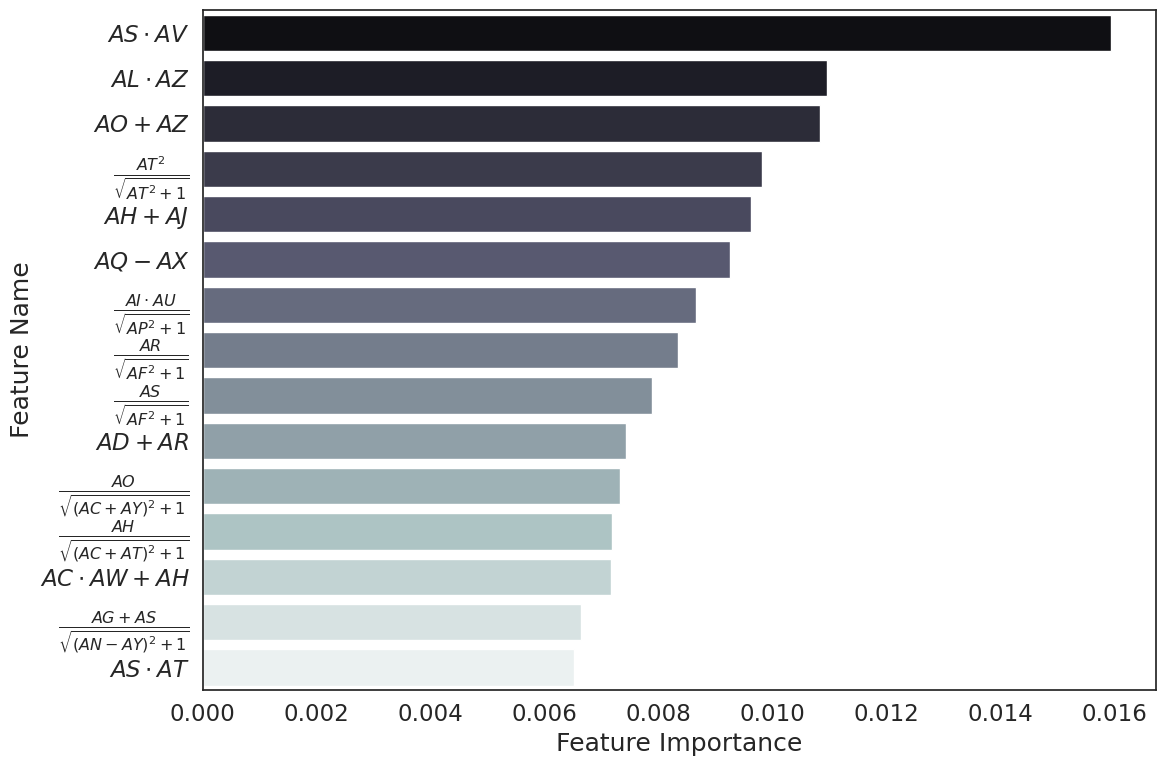

In [17]:
from evolutionary_forest.utils import get_feature_importance, plot_feature_importance

code_importance_dict = get_feature_importance(r)
plot_feature_importance(code_importance_dict)